# Entrenar modelo Schneiderman y Kanade

## Preparacion de datos
Las imagenes de caras estan en la carpeta no_faces.
Las imagenes de no caras se obtendran del data set de COCO, al cual se le cortaran segmentos de 80x80.

In [1]:
pip install pycocotools

  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 3.0 MB/s eta 0:00:0000:01
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 4.4 MB/s eta 0:00:00
Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.2 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 7.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, ru

In [25]:
from pycocotools.coco import COCO
import requests
import os

# Rutas
# annFile = './instances_val2017.json'
annFile = './instances_train2017.json'
save_dir = 'no_face_images/'
os.makedirs(save_dir, exist_ok=True)

# Cargar anotaciones
coco = COCO(annFile)

loading annotations into memory...
Done (t=15.50s)
creating index...
index created!


In [26]:
# Filtrar imagenes en las que no figuren caras

# ID de "person"
person_id = coco.getCatIds(catNms=['person'])[0]

# Todas las imágenes
img_ids = coco.getImgIds()
person_img_ids = set(coco.getImgIds(catIds=[person_id]))
no_person_img_ids = list(set(img_ids) - person_img_ids)

print(f"Se encontraron {len(no_person_img_ids)} imágenes sin personas.")


Se encontraron 54172 imágenes sin personas.


In [ ]:
# Generar parches de 80x80
import os
import cv2
import numpy as np
from tqdm import tqdm

def extract_random_patches(
    img, patch_size=(80, 80), num_patches=10, 
    min_brightness=30, min_distance=20, max_attempts=100
):
    patches = []
    used_coords = []
    h, w = img.shape[:2]
    ph, pw = patch_size
    attempts = 0

    while len(patches) < num_patches and attempts < max_attempts:
        x = np.random.randint(0, h - ph)
        y = np.random.randint(0, w - pw)
        patch = img[x:x+ph, y:y+pw]

        # Se descarta si imagen es muy oscura
        if patch.mean() < min_brightness:
            attempts += 1
            continue

        # Se descartan parches repetidos o solapados
        too_close = any(np.hypot(x - ux, y - uy) < min_distance for ux, uy in used_coords)
        if too_close:
            attempts += 1
            continue

        patches.append(patch)
        used_coords.append((x, y))
        attempts = 0

    return patches

In [27]:
# Se ejecuta desde contador de anterior ejecucion. Se detiene la ejecucion al conseguir cantidad considerable de imagenes
count = 23070
for img_id in tqdm(no_person_img_ids):
    img_info = coco.loadImgs(img_id)[0]
    url = img_info['coco_url']
    temp_path = f"temp.jpg"

    try:
        # Descargar imagen temporalmente
        r = requests.get(url, stream=True, timeout=10)
        with open(temp_path, 'wb') as f:
            for chunk in r.iter_content(1024):
                f.write(chunk)

        # Leer imagen y generar parches
        img = cv2.imread(temp_path)
        if img is None:
            os.remove(temp_path)
            continue

        patches = extract_random_patches(img)
        for patch in patches:
            out_path = os.path.join("no_face_80x80/", f"nonface_{count:06}.jpg")
            cv2.imwrite(out_path, patch)
            count += 1

        # Eliminar imagen temporal
        os.remove(temp_path)

    except Exception as e:
        print(f"Error procesando {img_info['file_name']}: {e}")
        if os.path.exists(temp_path):
            os.remove(temp_path)

print(f"Proceso finalizado. Total de parches generados: {count}")

 21%|██        | 11109/54172 [2:02:29<7:54:50,  1.51it/s] 


KeyboardInterrupt: 

## Entrenamiento

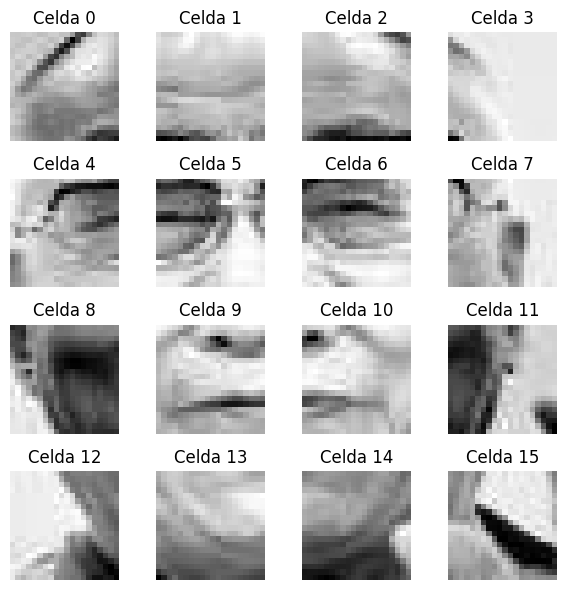

In [ ]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

GRID_SIZE = 4

def cargar_imagen_grises(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    return img


def dividir_en_celdas(img, grid_size=GRID_SIZE):
    h, w = img.shape
    celda_h = h // grid_size
    celda_w = w // grid_size
    celdas = []
    for i in range(grid_size):
        for j in range(grid_size):
            celda = img[i*celda_h:(i+1)*celda_h, j*celda_w:(j+1)*celda_w]
            celdas.append(celda)
    return celdas

imagen_np = cargar_imagen_grises("./face_images/13.jpg")
celdas = dividir_en_celdas(imagen_np)

# --- Prueba para ver las celdas ---
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(celdas[idx], cmap='gray')
    ax.set_title(f"Celda {idx}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [2]:
def aplicar_pca(data, varianza_objetivo):
    mean = np.mean(data, axis=0) # Calcular la media de los datos
    centered = data - mean # Restar a todos los datos la media
    cov = np.cov(centered, rowvar=False) # Calcular la matriz de covarianza
    eigvals, eigvecs = np.linalg.eigh(cov) # Calcular eigenvalores y eigenvectores
    idx = np.argsort(eigvals)[::-1] # Indices ordenados de mayor a menor
    eigvals = eigvals[idx] # eigenvalores ordenados de mayor a menor
    eigvecs = eigvecs[:, idx] # Ordenarlos seg´un los eigenvalores asociados

    # Calcular varianza acumulada
    var_acumulada = np.cumsum(eigvals) / np.sum(eigvals)
    n_components = np.searchsorted(var_acumulada, varianza_objetivo) + 1

    # Componentes principales
    W = eigvecs[:, :n_components]  # Todas las filas y de 0 a n_components-1 columnas
    return W, mean

In [3]:
def ajustar_gaussiana(datos):
    mean = np.mean(datos, axis=0)
    centered = datos - mean
    cov = np.cov(centered, rowvar=False)
    return mean, cov

In [12]:
VARIANZA_OBJETIVO = 0.90

def entrenar_modelo(carpeta_imagenes):
    datos_por_celda = [[] for _ in range(GRID_SIZE**2)]

    for filename in os.listdir(carpeta_imagenes):
        if filename.lower().endswith(('.jpg', '.png')):
            ruta = os.path.join(carpeta_imagenes, filename)
            imagen = cargar_imagen_grises(ruta)
            celdas = dividir_en_celdas(imagen)

            for idx, celda in enumerate(celdas):
                vector = celda.flatten()
                datos_por_celda[idx].append(vector)

    modelo = []
    for datos in datos_por_celda:
        datos = np.array(datos)
        W, mean_pca = aplicar_pca(datos, VARIANZA_OBJETIVO)

        datos_proyectados = (datos - mean_pca) @ W

        mean_gauss, cov_gauss = ajustar_gaussiana(datos_proyectados)

        modelo.append({
            'W': W,
            'mean_pca': mean_pca,
            'mean_gauss': mean_gauss,
            'cov_gauss': cov_gauss
        })

    return modelo


In [13]:
import pickle

def guardar_modelo(modelo, path='modelo_pca.pkl'):
    with open(path, 'wb') as f:
        pickle.dump(modelo, f)

In [14]:
import os

carpeta_caras = './face_images'
carpeta_nocaras = './no_face_80x80'

# Entrenamiento
modelo_cara = entrenar_modelo(carpeta_caras)
modelo_nocara = entrenar_modelo(carpeta_nocaras)

# Guardado
guardar_modelo(modelo_cara, 'modelo_pca_cara_gauss.pkl')
guardar_modelo(modelo_nocara, 'modelo_pca_nocara_gauss.pkl')